In [1]:
# libraries 
import numpy as np
import numpy.matlib
import cvxpy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import time
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import stats
import torch
import sklearn.linear_model
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import scipy.io as sio
import torch.nn.functional as F
from sklearn import svm
from sklearn.datasets import make_blobs

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [2]:
from data_utils import get_CIFAR10_data
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")


X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [3]:
def generate_sign_patterns(X, P, verbose=False): 
    """ 
    Inputs: X (input to the layer), P (number of samples, also number of neurons)
    Outputs: P, [D_1,...D_P], [u_1,...,u_P]
             where each D is Diag(1[X@u_i>=0]), u_i a random vector
    See remark 3.3 in (Pilanci&Ergen 2020)
    "The convex program (8) can be approximated by sampling a set
     of diagonal matrices D_1,...,D_P"
    """
    n, d = X.shape
    sign_pattern_list = []  # sign patterns, stores D_1,...,D_P
    u_vector_list = []      # random vectors used to generate the sign patterns

    for i in range(P): 
        # Obtain a sign pattern
        # Future work: use a different sampling distribution than Gaussian
        
        # First, sample u from normal distribution
        u = np.random.normal(0, 1, (d,1)) 
        
        # Our sign pattern is Diag(1[X@u_i>=0])
        sampled_sign_pattern = (np.matmul(X, u) >= 0)[:,0]
        
        sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(u)
    if verbose:
        print("Number of sign patterns generated: " + str(len(sign_pattern_list)))
    return len(sign_pattern_list), sign_pattern_list, u_vector_list

def generate_u_vectors_manual(prev_dim, P, verbose=False): 
    
    d = prev_dim
    u_vector_list = []      # random vectors used to generate the sign patterns

    for i in range(P): 
        # Obtain a sign pattern
        # Future work: use a different sampling distribution than Gaussian
        
        # First, sample u from normal distribution
        u = np.random.normal(0, 1, (d,1)) 
        
        u_vector_list.append(u)
    if verbose:
        print("Number of sign patterns generated: " + str(len(sign_pattern_list)))
    return u_vector_list

def one_hot(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels.long()] 

class PrepareData(Dataset):
    #  converts data from numpy array to torch tensor
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [6]:
# functions for solving the convex problem
# tutorial link: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
class custom_cvx_layer(torch.nn.Module):
    def __init__(self, n, d, num_neurons, u_vector_list):
        """
        Variables:
        w, v: matrices, arguments to the argmin of (8) in paper
        u_vectors_as_np: numpy array of vectors used to generate diagonals
        h: torch tensor of u_vectors_as_np
        """
        super(custom_cvx_layer, self).__init__()
        
        self.w = torch.nn.Parameter(data=torch.zeros(d, num_neurons), requires_grad=True)
        self.v = torch.nn.Parameter(data=torch.zeros(d, num_neurons), requires_grad=True)
        u_vectors_as_np = np.asarray(u_vector_list).reshape((num_neurons, d)).T
        self.h = torch.nn.Parameter(data=torch.Tensor(u_vectors_as_np), requires_grad=False)
        
    def forward(self, x):
        """
        Generates sign patterns on the fly, then carries out the prediction
        inside of (8)
        """
        sign_patterns = (torch.matmul(x, self.h) >= 0)
        Xv_w = torch.matmul(x, self.v - self.w)
        DXv_w = torch.mul(sign_patterns, Xv_w)
        y_pred = torch.sum(DXv_w, dim=1, keepdim=True)
        
        return y_pred

    
def get_nonconvex_cost(y, model, _x, beta):
    """
    Where does this come from? It doesn't look like (2)
    """
    Xv = torch.matmul(_x, model.v)
    Xw = torch.matmul(_x, model.w)
    Xv_relu = torch.max(Xv, torch.Tensor([0]))
    Xw_relu = torch.max(Xw, torch.Tensor([0]))
    
    prediction_w_relu = torch.sum(Xv_relu - Xw_relu, dim=1, keepdim=True)
    prediction_cost = 0.5 * torch.norm(prediction_w_relu - y)**2/y.shape[0]
    regularization_cost = (beta/2) * (torch.sum(torch.norm(model.v, dim=0)) + torch.sum(torch.norm(model.w, dim=0)))
     
    regularization_cost = 2 * regularization_cost # norm for u_j and alpha_j are the same, so just multiply by 2
    
    return prediction_cost + regularization_cost
    
def loss_func_cvxproblem(yhat, y, model, _x, beta, rho):
    """
    This implements the conex problem described by equation (8)
    """
    # term 1, the square-distance loss
    loss = 0.5 * torch.norm(yhat - y)**2/y.shape[0]
    
    # term 2, the regularization term
    m1=torch.mean(torch.norm(model.v, dim=0))
    m2=torch.mean(torch.norm(model.w, dim=0))
    norms1=torch.norm(model.v, dim=0)#*(torch.norm(model.v, dim=0)>=m1)
    norms2=torch.norm(model.w, dim=0)#*(torch.norm(model.w, dim=0)>=m2)
    loss = loss + beta * torch.sum(norms1)
    loss = loss + beta * torch.sum(norms2)
    
    # term 3, enforces the inequality constraints
    if rho>0:
        sign_patterns = (torch.matmul(_x, model.h) >= 0)

        Xv = torch.matmul(_x, model.v)
        DXv = torch.mul(sign_patterns, Xv)
        relu_term_v = torch.max(-2*DXv + Xv, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_v)

        Xw = torch.matmul(_x, model.w)
        DXw = torch.mul(sign_patterns, Xw)
        relu_term_w = torch.max(-2*DXw + Xw, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_w)
    
    return loss


def validation_cvxproblem(model, testloader, beta, rho):
    test_loss = 0
    test_correct = 0
    test_noncvx_cost = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float()
        _y = Variable(_y).float()

        yhat = model(_x).float()

        loss = loss_func_cvxproblem(yhat, _y, model, _x, beta, rho)
        test_loss += loss.item()
        test_correct += torch.eq(torch.sign(yhat), _y).float().sum()
        
        test_noncvx_cost += get_nonconvex_cost(_y, model, _x, beta)

    return test_loss, test_correct, test_noncvx_cost


def sgd_solver_cvxproblem(A_train, y_train, A_test, y_test, num_epochs, num_neurons, beta, 
                       learning_rate, batch_size, rho, u_vector_list, solver_type, LBFGS_param, verbose=False):
    
    device = torch.device('cpu')

    n, d = A_train.shape
    
    # create the model
    model = custom_cvx_layer(n, d, num_neurons, u_vector_list).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])#,
    
    # arrays for saving the loss and accuracy 
    losses = np.zeros((int(num_epochs*np.ceil(A_train.shape[0] / batch_size))))
    accs = np.zeros(losses.shape)
    noncvx_losses = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    noncvx_losses_test = np.zeros((num_epochs+1))
    
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    
    # dataset loaders (minibatch)
    ds = PrepareData(X=A_train, y=y_train)
    ds = DataLoader(ds, batch_size=batch_size, shuffle=True)
    ds_test = PrepareData(X=A_test, y=y_test)
    ds_test = DataLoader(ds_test, batch_size=A_test.shape[0], shuffle=False) # note batch_size
    
    losses_test[0], accs_test[0], noncvx_losses_test[0] = validation_cvxproblem(model, ds_test, beta, rho) # loss on the entire test set
    
    iter_no = 0
    for i in range(num_epochs):
        for ix, (_x, _y) in enumerate(ds):
            #=========make input differentiable=======================
            _x = Variable(_x).float()
            _y = Variable(_y).float()

            
            ####### this function is for LBFGS ######
            def closure():
                optimizer.zero_grad()
                yhat = model(_x).float()
                loss = loss_func_cvxproblem(yhat, _y, model, _x, beta, rho)
                loss.backward()
                return loss
            #########################################
            
            
            
            #========forward pass=====================================
            yhat = model(_x).float()
            
            loss = loss_func_cvxproblem(yhat, _y, model, _x, beta, rho)
            correct = torch.eq(torch.sign(yhat), _y).float().sum() # accuracy

            #=======backward pass=====================================
            if solver_type == "sgd":
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss
            elif solver_type == "LBFGS":
                optimizer.step(closure)
                

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            noncvx_losses[iter_no] = get_nonconvex_cost(_y, model, _x, beta)
        
            iter_no += 1
            times[iter_no] = time.time()
        
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1], noncvx_losses_test[i+1] = validation_cvxproblem(model, ds_test, beta, rho) # loss on the entire test set
        
        if i % 1 == 0:
            print("Epoch [{}/{}], TRAIN: noncvx/cvx loss: {}, {} acc: {}. TEST: noncvx/cvx loss: {}, {} acc: {}".format(i, num_epochs,
                    np.round(noncvx_losses[iter_no-1], 3), np.round(losses[iter_no-1], 3), np.round(accs[iter_no-1]/batch_size, 3), 
                    np.round(noncvx_losses_test[i+1], 3), np.round(losses_test[i+1], 3), np.round(accs_test[i+1]/A_test.shape[0], 3)))
            
    return noncvx_losses, accs/batch_size, noncvx_losses_test, accs_test/A_test.shape[0], times, model, losses, losses_test

class custom_cvx_layer_multilayer(torch.nn.Module):
    def __init__(self, n, d, num_neurons_list, u_vector_array, num_layers=1):
        super(custom_cvx_layer_multilayer, self).__init__()
        assert len(num_neurons_list) == num_layers
        assert len(u_vector_array) == num_layers
        
        self.num_layers = num_layers
        self.out_layer = 0
        self.v_list = torch.nn.ParameterList()
        self.w_list = torch.nn.ParameterList()
        self.h_list = torch.nn.ParameterList()
        for i in range(num_layers):
            if i == 0:
                prev_dimension = d
            else:
                prev_dimension = num_neurons_list[i - 1]
            self.v_list.append(torch.nn.Parameter(data=torch.zeros(prev_dimension, num_neurons_list[i]), requires_grad=True))
            self.w_list.append(torch.nn.Parameter(data=torch.zeros(prev_dimension, num_neurons_list[i]), requires_grad=True))
            u_vectors_as_np = np.float32(np.asarray(u_vector_array[i]).reshape((num_neurons_list[i], prev_dimension)).T)
            self.h_list.append(torch.nn.Parameter(data=torch.tensor(u_vectors_as_np), requires_grad=False))

    def set_out_layer(self, layer):
        self.out_layer = layer
        for i in range(self.num_layers):
            if i != layer:
                self.v_list[i].requires_grad = False
                self.w_list[i].requires_grad = False
            if i == layer:
                self.v_list[i].requires_grad = True
                self.w_list[i].requires_grad = True
                
    def current_vwh(self):
        v = self.v_list[self.out_layer]
        w = self.w_list[self.out_layer]
        h = self.h_list[self.out_layer]
        return v, w, h
    
    def current_layer_input(self, x):
        next_input = x
        for i in range(self.out_layer):
            sign_patterns = (torch.matmul(next_input, self.h_list[i]) >= 0)
            Xv_w = torch.matmul(next_input, self.v_list[i] - self.w_list[i])
            DXv_w = torch.mul(sign_patterns, Xv_w)
            next_input = DXv_w
            
        return next_input

    def forward(self, x):
        next_input = self.current_layer_input(x)
        sign_patterns = (torch.matmul(next_input, self.h_list[self.out_layer]) >= 0)
        Xv_w = torch.matmul(next_input, self.v_list[self.out_layer] - self.w_list[self.out_layer])
        DXv_w = torch.mul(sign_patterns, Xv_w)
        y_pred = torch.sum(DXv_w, dim=1, keepdim=True)
        return y_pred

def loss_func_cvxproblem_multilayer(yhat, y, model, _x, beta, rho):
    """
    This implements the convex problem described by equation (8)
    """
    # term 1, the square-distance loss
    loss = 0.5 * torch.norm(yhat - y)**2/y.shape[0]
    
    # term 2, the regularization term
    v, w, h = model.current_vwh()
    m1=torch.mean(torch.norm(v, dim=0))
    m2=torch.mean(torch.norm(w, dim=0))
    norms1=torch.norm(v, dim=0)
    norms2=torch.norm(w, dim=0)
    loss = loss + beta * torch.sum(norms1)
    loss = loss + beta * torch.sum(norms2)
    
    # term 3, enforces the inequality constraints
    if rho>0:
        current_input = model.current_layer_input(_x)
        sign_patterns = (torch.matmul(current_input, h) >= 0)
        Xv = torch.matmul(current_input, v)
        DXv = torch.mul(sign_patterns, Xv)
        relu_term_v = torch.max(-2*DXv + Xv, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_v)

        Xw = torch.matmul(current_input, w)
        DXw = torch.mul(sign_patterns, Xw)
        relu_term_w = torch.max(-2*DXw + Xw, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_w)
    
    return loss


def validation_cvxproblem_multilayer(model, testloader, beta, rho):
    test_loss = 0
    test_correct = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float()
        _y = Variable(_y).float()

        yhat = model(_x).float()

        loss = loss_func_cvxproblem_multilayer(yhat, _y, model, _x, beta, rho)
        test_loss += loss.item()
        test_correct += torch.eq(torch.sign(yhat), _y).float().sum()

    return test_loss, test_correct
    
def sgd_solver_cvxproblem_multilayer(A_train, y_train, A_test, y_test, num_epochs, num_neurons_list, beta, 
                       learning_rate, batch_size, rho, u_vector_array, verbose=False):
    
    device = torch.device('cpu')

    n, d = A_train.shape
    
    # create the model
    num_layers = len(num_neurons_list)
    model = custom_cvx_layer_multilayer(n, d, num_neurons_list, u_vector_array, num_layers).to(device)
    
    # arrays for saving the accuracy
    losses = np.zeros((num_layers, int(num_epochs*np.ceil(A_train.shape[0] / batch_size)))) 
    accs = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_layers, num_epochs+1))
    accs_test = np.zeros((num_layers, num_epochs+1))

    
    times = np.zeros((losses.shape[1] * num_layers + 1))
    times[0] = time.time()
    
    # dataset loaders (minibatch)
    ds = PrepareData(X=A_train, y=y_train)
    ds = DataLoader(ds, batch_size=batch_size, shuffle=True)
    ds_test = PrepareData(X=A_test, y=y_test)
    ds_test = DataLoader(ds_test, batch_size=A_test.shape[0], shuffle=False) # note batch_size
    
    time_iter = 0
    for L in range(num_layers):
        print("Training layer ", L, " with learning rate ", learning_rate[L])
        model.set_out_layer(L)
        losses_test[L][0], accs_test[L][0] = validation_cvxproblem_multilayer(model, ds_test, beta, rho) # loss on the entire test set
        iter_no = 0
        # new optimizer to reset momentum so that it doesn't update frozen layers
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate[L])
    
        for i in range(num_epochs):
            for ix, (_x, _y) in enumerate(ds):
                #=========make input differentiable=======================
                _x = Variable(_x).float()
                _y = Variable(_y).float()

                #========forward pass=====================================
                yhat = model(_x).float()

                loss = loss_func_cvxproblem_multilayer(yhat, _y, model, _x, beta, rho)
                correct = torch.eq(torch.sign(yhat), _y).float().sum() # accuracy

                #=======backward pass=====================================
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss

                losses[L][iter_no] = loss.item() # loss on the minibatch
                accs[L][iter_no] = correct

                iter_no += 1
                time_iter += 1
                times[time_iter] = time.time()

            # get test loss and accuracy
            losses_test[L][i+1], accs_test[L][i+1] = validation_cvxproblem_multilayer(model, ds_test, beta, rho) # accuracy on the entire test set

            if i % 1 == 0:
                print("Epoch [{}/{}], TRAIN: cvx loss: {} acc: {}. TEST: cvx loss: {} acc: {}".format(i, num_epochs,
                    np.round(losses[L][iter_no-1], 3), np.round(accs[L][iter_no-1]/batch_size, 3), 
                    np.round(losses_test[L][i+1], 3), np.round(accs_test[L][i+1]/A_test.shape[0], 3)))
            
    return accs/batch_size, accs_test/A_test.shape[0], times, model, losses, losses_test

In [4]:
# cifar-10 -- using the version downloaded from "http://www.cs.toronto.edu/~kriz/cifar.html"
# A=sio.loadmat('CIFAR10_multiclass.mat')['A']
# A_test=sio.loadmat('CIFAR10_multiclass.mat')['Atest']
# y=sio.loadmat('CIFAR10_multiclass.mat')['y1']
# y_test=sio.loadmat('CIFAR10_multiclass.mat')['ytest1']

A = data['X_train']
A = A.reshape((A.shape[0], -1))
A_test = data['X_val']
A_test = A_test.reshape((A_test.shape[0], -1))
y = data['y_train']  # changed y to y_ints
y_test = data['y_val']  # changed y_test to y_test_ints

# """ Our changes """
# y = np.zeros((y_ints.shape[0], 10))
# y[np.arange(y.shape[0]), y_ints] = 1
# y_test = np.zeros((y_test_ints.size, 10))
# y_test[np.arange(y_test_ints.size), y_test_ints] = 1

meanA=np.mean(A,axis=0)
A=A-meanA
A_test=A_test-meanA


# to get the first two classes only (for binary classification)
inds = np.argwhere(y <= 1)[:,0] # get the classes 0 and 1
A = A[inds, :]
y = y[inds].reshape((inds.shape[0], 1))
y=2*y.astype(float)-1
inds_test = np.argwhere(y_test <= 1)[:,0] # get the classes 0 and 1
A_test = A_test[inds_test, :]
y_test = y_test[inds_test].reshape((inds_test.shape[0], 1))
y_test=2*y_test.astype(float)-1



n, d = A.shape
print(A.shape, y.shape, A_test.shape, y_test.shape)


(9794, 3072) (9794, 1) (206, 3072) (206, 1)


In [16]:
# SGD solver for the nonconvex problem
# generate random sign patterns
P, verbose = 500, True # P is number of sign patterns to generate *and* number of neurons
num_epochs, batch_size = 50, 200

num_neurons, sign_pattern_list, u_vector_list = generate_sign_patterns(A, P, verbose)
beta=1e-3
rho = 1e-5
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rates = [1e-7, 1e-3] # one per layer

# binary classifier one layer
# results_cvx = sgd_solver_cvxproblem(A, y, A_test, y_test, num_epochs, num_neurons, beta, 
#                         learning_rate, batch_size, rho, u_vector_list, solver_type, LBFGS_param, verbose)

# binary classifier multilayer
# TODO: new sign_patterns_array generator
num_epochs = 50
num_neurons_list = [P, P]
u_vector_list_2 = generate_u_vectors_manual(P, P, verbose)
# u_vector_list_3 = generate_u_vectors_manual(P, P, verbose)
u_vector_array = [u_vector_list, u_vector_list_2]
results_cvx = sgd_solver_cvxproblem_multilayer(A, y, A_test, y_test, num_epochs, num_neurons_list, beta, 
                       learning_rates, batch_size, rho, u_vector_array, verbose=False)

Number of sign patterns generated: 500
Number of sign patterns generated: 500
Training layer  0  with learning rate  1e-07
Epoch [0/50], TRAIN: cvx loss: 0.29 acc: 0.805. TEST: cvx loss: 0.287 acc: 0.811
Epoch [1/50], TRAIN: cvx loss: 0.206 acc: 0.88. TEST: cvx loss: 0.218 acc: 0.908
Epoch [2/50], TRAIN: cvx loss: 0.206 acc: 0.89. TEST: cvx loss: 0.22 acc: 0.883
Epoch [3/50], TRAIN: cvx loss: 0.212 acc: 0.86. TEST: cvx loss: 0.222 acc: 0.879
Epoch [4/50], TRAIN: cvx loss: 0.175 acc: 0.89. TEST: cvx loss: 0.198 acc: 0.903
Epoch [5/50], TRAIN: cvx loss: 0.126 acc: 0.93. TEST: cvx loss: 0.218 acc: 0.893
Epoch [6/50], TRAIN: cvx loss: 0.114 acc: 0.94. TEST: cvx loss: 0.194 acc: 0.903
Epoch [7/50], TRAIN: cvx loss: 0.102 acc: 0.95. TEST: cvx loss: 0.194 acc: 0.922
Epoch [8/50], TRAIN: cvx loss: 0.079 acc: 0.965. TEST: cvx loss: 0.197 acc: 0.917
Epoch [9/50], TRAIN: cvx loss: 0.088 acc: 0.95. TEST: cvx loss: 0.213 acc: 0.903
Epoch [10/50], TRAIN: cvx loss: 0.081 acc: 0.96. TEST: cvx loss: 0.

Epoch [49/50], TRAIN: cvx loss: 0.113 acc: 0.965. TEST: cvx loss: 0.314 acc: 0.859


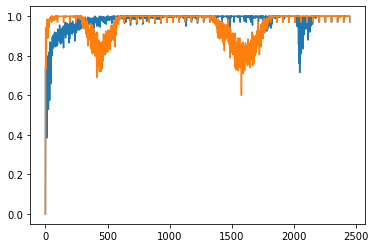

In [13]:
train_accs = results_cvx[0]
for i in range(train_accs.shape[0]):
    plt.plot(train_accs[i])
plt.show()

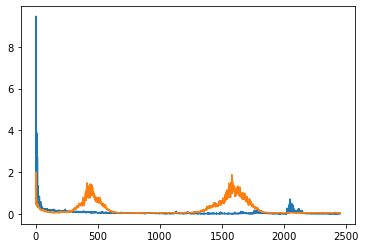

In [14]:
plt.clf()
train_losses = results_cvx[4]
for i in range(train_losses.shape[0]):
    plt.plot(train_losses[i])
plt.show()

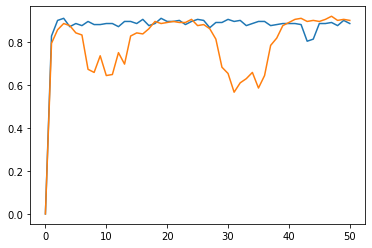

In [10]:
plt.clf()
test_accs = results_cvx[1]
for i in range(test_accs.shape[0]):
    plt.plot(test_accs[i])
plt.show()

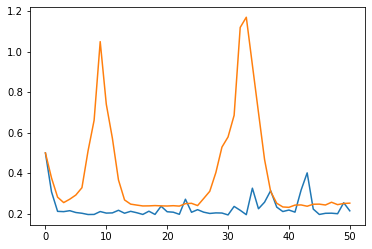

In [15]:
plt.clf()
test_losses = results_cvx[5]
for i in range(test_losses.shape[0]):
    plt.plot(test_losses[i])
plt.show()